# DEEP LEANINNG MODEL - DeiT-Small-Distilled

In [11]:
# =========================
# Cell 0 — WSL path helper + dataset peek
# =========================
import os, platform, glob
from pathlib import PureWindowsPath

def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"

def peek_some_images(root, classes=("CNV","DME","DRUSEN","NORMAL"), max_show=3):
    print(f"\nPeeking into: {root}")
    for split in ("train","val","test"):
        split_dir = os.path.join(root, split)
        print(f"\n[{split}] exists: {os.path.isdir(split_dir)} -> {split_dir}")
        for cls in classes:
            cls_dir = os.path.join(split_dir, cls)
            imgs = []
            if os.path.isdir(cls_dir):
                for pat in ("*.png","*.jpg","*.jpeg","*.tif","*.bmp"):
                    imgs.extend(glob.glob(os.path.join(cls_dir, pat)))
            print(f"  {cls:<7} -> {len(imgs):6d} files | path: {cls_dir}")
            for s in imgs[:max_show]:
                print("    -", os.path.basename(s))

# --- Your Windows dataset path & save folder (edit if needed) ---
WIN_DATA_ROOT = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15"
WIN_MODELS_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"

DATA_ROOT   = win_to_wsl_path(WIN_DATA_ROOT)
MODELS_DIR  = win_to_wsl_path(WIN_MODELS_DIR)

print("Running in WSL:", is_wsl())
print("DATA_ROOT  ->", DATA_ROOT)
print("MODELS_DIR ->", MODELS_DIR)
peek_some_images(DATA_ROOT)


Running in WSL: True
DATA_ROOT  -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15
MODELS_DIR -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models

Peeking into: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15

[train] exists: True -> /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train
  CNV     ->  26216 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/CNV
    - CNV-1016042-1.png
    - CNV-1016042-10.png
    - CNV-1016042-100.png
  DME     ->   8116 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/DME
    - DME-1072015-1.png
    - DME-1072015-2.png
    - DME-1072015-3.png
  DRUSEN  ->   6201 files | path: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/dataset/OCT2017_70_15_15/train/DRUS

In [12]:
# =========================
# Cell 1 — Imports, device, reproducibility
# =========================
import os, time, copy, random, gc
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, datasets
from torch.cuda.amp import GradScaler
from contextlib import nullcontext

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Speed knobs
torch.backends.cudnn.benchmark = True
if hasattr(torch.backends.cuda.matmul, "allow_tf32"):
    torch.backends.cuda.matmul.allow_tf32 = True
if hasattr(torch.backends.cudnn, "allow_tf32"):
    torch.backends.cudnn.allow_tf32 = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available(): print("GPU:", torch.cuda.get_device_name(0))

def clean_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Autocast context (new API if available)
if hasattr(torch, "amp"):
    def autocast_ctx():
        return torch.amp.autocast(device_type="cuda") if torch.cuda.is_available() else nullcontext()
else:
    from torch.cuda.amp import autocast
    def autocast_ctx():
        return autocast() if torch.cuda.is_available() else nullcontext()

# Workers (safer defaults)
if os.name == "nt" and not is_wsl():
    DEFAULT_WORKERS = 0
else:
    DEFAULT_WORKERS = min(8, os.cpu_count() or 2)


Torch: 2.8.0+cu128
CUDA available: True
GPU: NVIDIA GeForce GTX 1650 Ti


In [21]:
# =========================
# Cell 2 — Config & structure check
# =========================
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val")
TEST_DIR  = os.path.join(DATA_ROOT, "test")

EXPECTED_CLASSES = ["CNV", "DME", "DRUSEN", "NORMAL"]

# Training config
IMG_SIZE      = 224
BATCH_SIZE    = 16
NUM_WORKERS   = DEFAULT_WORKERS
EPOCHS        = 5
LR            = 3e-4
WEIGHT_DECAY  = 0.05   # good for ViT/DeiT
LABEL_SMOOTH  = 0.05
MODEL_NAME    = "deit_small_distilled_patch16_224"
PATIENCE      = 5

os.makedirs("checkpoints", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

def check_structure(root, splits=("train","val","test"), classes=EXPECTED_CLASSES):
    problems = []
    for split in splits:
        split_path = os.path.join(root, split)
        if not os.path.isdir(split_path): problems.append(f"Missing split folder: {split_path}"); continue
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            if not os.path.isdir(cls_path): problems.append(f"Missing class folder: {cls_path}")
            else:
                has_img = any(fn.lower().endswith((".png",".jpg",".jpeg",".tif",".bmp"))
                              for fn in os.listdir(cls_path))
                if not has_img:
                    problems.append(f"No image files in: {cls_path} (OneDrive hydrate?)")
    if problems:
        print("❌ Structure issues:")
        for p in problems: print(" -", p)
        raise FileNotFoundError("Fix dataset structure before continuing.")
    print("✅ Dataset structure looks good.")

check_structure(DATA_ROOT)


✅ Dataset structure looks good.


In [22]:
# =========================
# Cell 3 — Discover data & counts
# =========================
tmp_train = datasets.ImageFolder(TRAIN_DIR)
tmp_val   = datasets.ImageFolder(VAL_DIR)
tmp_test  = datasets.ImageFolder(TEST_DIR)

class_names = tmp_train.classes
print("Classes:", class_names)
assert sorted(class_names) == sorted(EXPECTED_CLASSES), "Classes on disk don't match EXPECTED_CLASSES."

from collections import Counter
def count_per_class(ds):
    cnt = Counter([y for _, y in ds.samples])
    return {class_names[i]: cnt[i] for i in range(len(class_names))}

print("Train counts:", count_per_class(tmp_train))
print("Val counts  :", count_per_class(tmp_val))
print("Test counts :", count_per_class(tmp_test))


Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']
Train counts: {'CNV': 26216, 'DME': 8116, 'DRUSEN': 6201, 'NORMAL': 18593}
Val counts  : {'CNV': 5618, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}
Test counts : {'CNV': 5617, 'DME': 1739, 'DRUSEN': 1329, 'NORMAL': 3984}


In [23]:
# =========================
# Cell 4 — Transforms
# =========================
base_train_t = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # DeiT expects 3ch (ImageNet stats)
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def heavy_aug_t():
    return transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(0.6),
        transforms.RandomVerticalFlip(0.15),
        transforms.RandomApply([transforms.RandomRotation(10)], p=0.6),
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.95,1.05))], p=0.6),
        transforms.RandomApply([transforms.ColorJitter(0.10, 0.10)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])

base_eval_t = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])


In [24]:
# =========================
# Cell 5 — Datasets, sampler, loaders
# =========================
class ClassAwareImageFolder(Dataset):
    def __init__(self, root, default_transform, class_transforms=None):
        self.inner = datasets.ImageFolder(root=root)
        self.default_transform = default_transform
        self.class_transforms = class_transforms or {}
        self.name_to_idx = self.inner.class_to_idx
        self.idx_to_transform = {}
        for name, t in self.class_transforms.items():
            if name in self.name_to_idx:
                self.idx_to_transform[self.name_to_idx[name]] = t

    def __len__(self): return len(self.inner)

    def __getitem__(self, i):
        path, label = self.inner.samples[i]
        img = self.inner.loader(path)  # PIL image
        t = self.idx_to_transform.get(label, self.default_transform)
        img = t(img)
        return img, label

    @property
    def samples(self): return self.inner.samples
    @property
    def classes(self): return self.inner.classes

# minority classes in TRAIN
train_counts = Counter([y for _, y in tmp_train.samples])
counts_list = [train_counts[i] for i in range(len(class_names))]
median_count = sorted(counts_list)[len(counts_list)//2]
minority_idx = [i for i, c in enumerate(counts_list) if c <= median_count]
minority_names = [class_names[i] for i in minority_idx]
print("Minority classes (heavier aug):", minority_names)
class_transforms = {n: heavy_aug_t() for n in minority_names}

# Build datasets
train_ds = ClassAwareImageFolder(TRAIN_DIR, default_transform=base_train_t, class_transforms=class_transforms)
val_ds   = ClassAwareImageFolder(VAL_DIR,   default_transform=base_eval_t)
test_ds  = ClassAwareImageFolder(TEST_DIR,  default_transform=base_eval_t)

# Weighted sampler (balance training batches)
class_count_map = Counter([y for _, y in train_ds.samples])
sample_weights = [1.0 / class_count_map[y] for _, y in train_ds.samples]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

def worker_init_fn(worker_id): np.random.seed(SEED + worker_id)

pin = torch.cuda.is_available()
persist = NUM_WORKERS > 0

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, sampler=sampler,
    num_workers=NUM_WORKERS, pin_memory=pin,
    persistent_workers=persist, prefetch_factor=4,
    worker_init_fn=worker_init_fn
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin,
    persistent_workers=persist, prefetch_factor=4
)
test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=pin,
    persistent_workers=persist, prefetch_factor=4
)

print("Batches -> train/val/test:", len(train_loader), len(val_loader), len(test_loader))


Minority classes (heavier aug): ['DME', 'DRUSEN', 'NORMAL']
Batches -> train/val/test: 3696 792 792


In [25]:
# =========================
# Cell 6 — Build DeiT-Small-Distilled (timm)
# =========================
try:
    import timm
except ImportError:
    import sys, subprocess
    print("Installing timm...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm"])
    import timm

def build_model(num_classes: int, name: str = "deit_small_distilled_patch16_224"):
    model = timm.create_model(name, pretrained=True, num_classes=num_classes)
    return model

model = build_model(num_classes=len(class_names), name=MODEL_NAME).to(DEVICE)

# Optional compile (PyTorch 2.x)
try:
    model = torch.compile(model)
    print("torch.compile enabled")
except Exception as e:
    print("compile skipped:", e)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model: {MODEL_NAME} | Params: {total_params/1e6:.2f}M")


torch.compile enabled
Model: deit_small_distilled_patch16_224 | Params: 21.67M


In [26]:
# =========================
# Cell 7 — Loss, optimizer, scheduler, scaler
# =========================
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = GradScaler()


/tmp/ipykernel_649/1071609347.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [27]:
# =========================
# Cell 8 — Train/Eval helpers
# =========================
@torch.no_grad()
def evaluate(loader, model):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        logits = model(x)
        preds = logits.argmax(1)
        all_y.append(y.cpu().numpy()); all_p.append(preds.cpu().numpy())
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    return acc, macro_f1, cm, y_true, y_pred

def train_one_epoch(model, loader, optimizer, scaler, criterion):
    model.train()
    running_loss, seen = 0.0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast_ctx():
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * x.size(0)
        seen += x.size(0)
    return running_loss / max(1, seen)

def plot_history(history, save_prefix=None):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o', label="Train Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss Curve"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"], 'g-o', label="Val Accuracy")
    plt.plot(epochs, history["val_f1"],  'r-o', label="Val F1")
    plt.xlabel("Epoch"); plt.ylabel("Score"); plt.title("Validation Accuracy & F1"); plt.legend()
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_curves.png", dpi=200, bbox_inches="tight")
    plt.show()

def save_checkpoint(model_state, classes, epoch, val_acc, val_f1, prefix):
    ckpt = {
        "model_state": model_state,
        "classes": classes,
        "epoch": epoch,
        "val_acc": float(val_acc),
        "val_f1": float(val_f1),
        "config": {"MODEL_NAME": MODEL_NAME, "IMG_SIZE": IMG_SIZE, "BATCH_SIZE": BATCH_SIZE, "LR": LR, "WEIGHT_DECAY": WEIGHT_DECAY}
    }
    path = f"checkpoints/{prefix}.pth"
    torch.save(ckpt, path)
    # mirror to your Windows folder
    torch.save(ckpt, os.path.join(MODELS_DIR, f"{prefix}.pth"))
    return path


Epoch 01 | loss 0.5844 | val_acc 0.8806 | val_f1 0.8413 | lr 2.71e-04 | 4644.6s
  ↳ Saved best checkpoint to: checkpoints/deit_small_distilled_patch16_224_best.pth


Epoch 02 | loss 0.4756 | val_acc 0.8634 | val_f1 0.8323 | lr 1.96e-04 | 4588.5s


Epoch 03 | loss 0.4201 | val_acc 0.8934 | val_f1 0.8630 | lr 1.04e-04 | 4592.8s
  ↳ Saved best checkpoint to: checkpoints/deit_small_distilled_patch16_224_best.pth


Epoch 04 | loss 0.3736 | val_acc 0.9103 | val_f1 0.8838 | lr 2.86e-05 | 4594.4s
  ↳ Saved best checkpoint to: checkpoints/deit_small_distilled_patch16_224_best.pth


Epoch 05 | loss 0.3330 | val_acc 0.9047 | val_f1 0.8805 | lr 0.00e+00 | 4595.2s


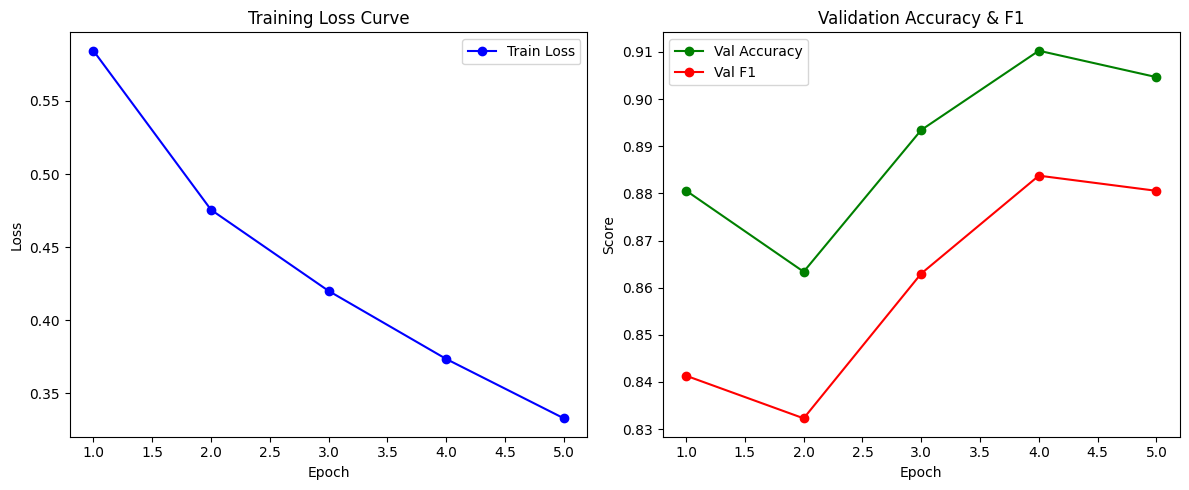

In [28]:
# =========================
# Cell 9 — Train on (train) with val, early-stop on val_f1
# =========================
history = {"train_loss": [], "val_acc": [], "val_f1": []}
best_state, best_f1, bad = None, -1, 0

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, scaler, criterion)
    val_acc, val_f1, val_cm, yv, pv = evaluate(val_loader, model)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"Epoch {epoch:02d} | loss {train_loss:.4f} | val_acc {val_acc:.4f} | val_f1 {val_f1:.4f} | "
          f"lr {scheduler.get_last_lr()[0]:.2e} | {time.time()-t0:.1f}s")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_state = copy.deepcopy(model.state_dict())
        ck_name = f"{MODEL_NAME}_best"
        ck_path = save_checkpoint(best_state, class_names, epoch, val_acc, val_f1, ck_name)
        print("  ↳ Saved best checkpoint to:", ck_path)
        bad = 0
    else:
        bad += 1
        if bad >= PATIENCE:
            print("  ↳ Early stopping.")
            break

clean_mem()

if best_state is not None:
    model.load_state_dict(best_state)

# Curves
plot_history(history, save_prefix=f"runs/{MODEL_NAME}")



=== TEST RESULTS ===
Accuracy : 0.9102
Macro F1 : 0.8841

Classification Report:
              precision    recall  f1-score   support

         CNV     0.9886    0.8674    0.9240      5617
         DME     0.9077    0.9448    0.9259      1739
      DRUSEN     0.6364    0.8638    0.7328      1329
      NORMAL     0.9372    0.9709    0.9538      3984

    accuracy                         0.9102     12669
   macro avg     0.8675    0.9117    0.8841     12669
weighted avg     0.9244    0.9102    0.9136     12669



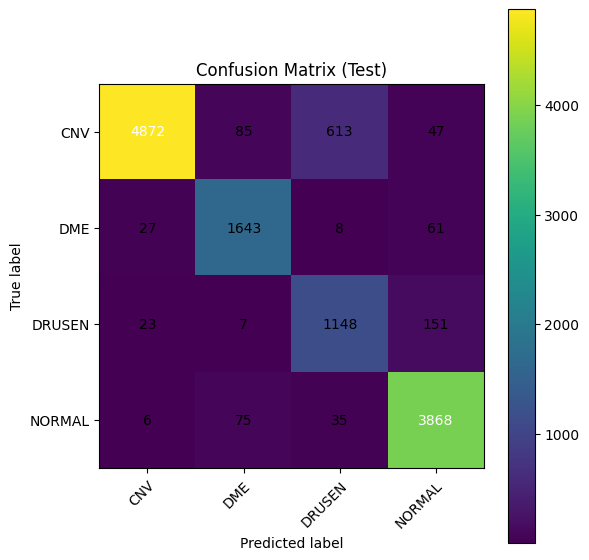

In [29]:
# =========================
# Cell 10 — Test evaluation & confusion matrix
# =========================
test_acc, test_f1, test_cm, y_true, y_pred = evaluate(test_loader, model)

print("\n=== TEST RESULTS ===")
print("Accuracy :", round(test_acc, 4))
print("Macro F1 :", round(test_f1, 4))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix Plot (and save)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(test_cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(class_names)), yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label', xlabel='Predicted label', title='Confusion Matrix (Test)')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = test_cm.max() / 2.
for i in range(test_cm.shape[0]):
    for j in range(test_cm.shape[1]):
        ax.text(j, i, format(test_cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if test_cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig("runs/confusion_matrix_test.png", dpi=200, bbox_inches="tight")
plt.show()


In [30]:
# =========================
# Cell 11 — Save final weights (.pth and .pkl) to Windows folder
# =========================
import pickle

state = model.state_dict()
pth_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_weights.pth")
pkl_path = os.path.join(MODELS_DIR, f"{MODEL_NAME}_oct2017_final_weights.pkl")

torch.save(state, pth_path)
with open(pkl_path, "wb") as f: pickle.dump(state, f)

print("Saved:", pth_path)
print("Saved:", pkl_path)


Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/deit_small_distilled_patch16_224_oct2017_final_weights.pth
Saved: /mnt/c/Users/sheno/OneDrive/CODCSD201F-006-SetupFile/Desktop/FINAL/models/deit_small_distilled_patch16_224_oct2017_final_weights.pkl
